In [25]:
from cycloneFilter import cycloneFilter
from solid import *
from solid.utils import *
import viewscad

In [49]:
def cycloneArray(init_params, delta_params, length, width):
    '''
    build sequential/parallel array of cyclone filters in a cartesian grid pattern.
    starts with a row of length parallel_filters of cycloneFilter object and iterates for
    sequential_filters altering cycloneFilter parameters by delta_params at each sequence.
    
    Parameters:
            init_params: list of cycloneFilter positional parameters to start from
            delta_params: list of values that will change each respective positional init_params
            width: array size containing parallel filters 
            length: array size containing sequential filters
    '''
    #TODO: add z dimension (always want to have length fill entire 
    #      z dimension for efficient filter)
    
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2, intakeSlitLength=10,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    #TODO: move this into iterator, can be used to calculate if a extra filter can be added.
    params = init_params
    curPosition = [0,0]
    array = None
        
    while True: #sequential loop
        #TODO: even and odd iterate differently
        print('in the loop')
        params = [x - y for x,y in zip(params, delta_params)]
        #distance between each filter
        xDistance = 2*params[6] + params[8]
        yDistance = xDistance + 2*params[2] #diameter but considers intake manifold
        
        curPosition[1] += yDistance #y position
        curPosition[0] = 0 #carriage return x axis
        
        #TODO: works as long as xDistance is diameter + bufferSpace
        parallelFilters = width//xDistance
        
        #TODO: check if runs over the length of the array and break
        if curPosition[1] > length:
            print('EOL: filter sequence')
            break
        
        if parallelFilters%2 == 0:
            print('odd')
            #start from origin then offset each filter origin+xDistance
            initialFilter = cycloneFilter(*params)
            initialFilter = left(curPosition[0])(initialFilter)
            initialFilter = forward(curPosition[1])(initialFilter)
            if array is None:
                array = initialFilter
            else:
                array+=initialFilter
            curPosition[0] += xDistance
            
            #parallel loop parallel_filters is int so /2 is okay
            #TODO: this is likely overstepping the area? double check this
            for x in range(int((parallelFilters-1)//2)): 
                #TODO: can also iterate until the edge is met to fill area
                
                leftFilter = cycloneFilter(*params)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)
                
                rightFilter = cycloneFilter(*params)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                array+=leftFilter
                array+=rightFilter
                
        else:
            print('even')
            #start from origin + xDistance/2
            curPosition[0] += xDistance/2
            for x in range(int(parallelFilters//2)): #parallel loop

                leftFilter = cycloneFilter(*params)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)

                rightFilter = cycloneFilter(*params)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)
                curPosition[0] += xDistance
                
                
                array+=leftFilter
                array+=rightFilter   
    return array

in the loop
odd
in the loop
even
in the loop
even
in the loop
odd
in the loop
even
in the loop
odd
in the loop
even
in the loop
odd
in the loop
EOL: filter sequence
done <solid.objects.union object at 0x75b305d438>


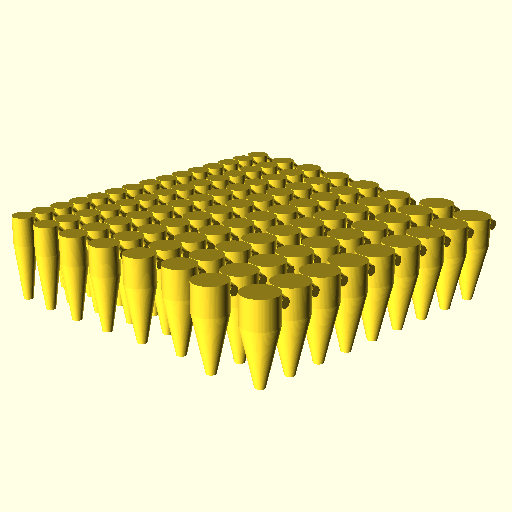

In [50]:
#POSITIONAL LEGEND:
# initParams=[intakeSlitHeight=10, intakeSlitWidth=2, intakeSlitLength=10,
#     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
#     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
# init_params=[10, 2, 4,
#             True, 5, 30,
#             10, 15, 0.05]
init_params=[1000, 200, 400,
            True, 500, 3000,
            1000, 1500, 0.5]
#NOTE: boolean parameter is 0 to null diff operator
#      during iteration.
#TODO: non-linear deltas, functionally pass in a polynomial, or define a polynomial for each member
#      in the delta-matrix and call across instead of differencing

#NOTE: cylinderHeight >= intakeSlitLength + cylinderHeight
delta_params=[0, 0, 0,
              0, 0, 0,
              50, 0, 0]
# cycloneFilter(*init_params)
cycloneArray = cycloneArray(init_params, delta_params,20000, 20000)
print('done', cycloneArray)
cycloneArray

In [11]:
############# Writeout Filter Model #############
scad_render_to_file(
    cycloneArray,
    "cycloneArray.scad",
)

AttributeError: 'NoneType' object has no attribute 'children'

In [24]:
#center point of intake:
#center point of outlet:

True

### MANIFOLD PIPELINE AND INTERFACES
- make a manifold tracer that pathplans to and from each filter between layers extrude along path with cylinder, needing only to define line equations mapping to inlet center from main intake pipeline. Main intake pipeline runs from vacuum inlet to fan exhaust and daisy chains filter rows. 
- intake needs a grid for coarse grain filtering and exhaust needs cone slope to match radial compressor

### CONSTRAINTS 
- consider constructing array by smallest filter (last row) since large filters dont fit well.
- increase  parallel splits based on intake cross sectional area to keep total cross sectional area across all filters the same per layer

- arrayConstraints for parametric interface: rect. prism [x,y,z]
- cycloneArray() solves for fitting optimization and delta_params sets per-filter geometry

### TODOS 
- need to set intake and outlet area constraint when calling cycloneFilter to make cycloneArray have the same sum cross-sectional area

### FUTURE DEVELOPMENT
- create a radial array arrangement as well, attempt to reuse fitting optimization code from cycloneArray() for abstract geometries


In [115]:
def oldCycloneArray(init_params, delta_params, length, width):
    '''
    build sequential/parallel array of cyclone filters in a cartesian grid pattern.
    starts with a row of length parallel_filters of cycloneFilter object and iterates for
    sequential_filters altering cycloneFilter parameters by delta_params at each sequence.
    
    Parameters:
            init_params: list of cycloneFilter positional parameters to start from
            delta_params: list of values that will change each respective positional init_params
            length: array size of parallel filters connected to the array's intake manifold
            width: array size of sequential filters iterating over delta_params
    '''
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2, intakeSlitLength=10,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    #TODO: move this into iterator, can be used to calculate if a extra filter can be added.
    params = init_params
    curPosition = [0,0]
    
    xDistance = 2*params[6] + params[8]
    yDistance = xDistance + 2*params[2]
    
    if length%2 == 0:
        middle_symmetry = length/2
    else:
        middle_symmetry = None
    array = None
    
    
    #TODO: alter iterators here based on fiting.
    # cylinderRadius is the only parameter necessary for fitting.
    # length//cylinderRadius = number of parallel filters in a row.
    #
    # just need to ensure cross sectional area is the same throughout
    # this should be configured by the last row?
    
    for seq in range(width):
        curPosition[0] = 0 #carriage return x axis
        
        #iterate filter parameters and spacing
        #TODO: spacing needs to also consider previous layers 
        params = [x - y for x,y in zip(params, delta_params)]
        xDistance= 2*params[6] + params[8]
        yDistance= xDistance + 2*params[2] #params[6] + 
        #iterate row
        curPosition[1] += yDistance
        
        for par in range(length):
            #iterate column
            #TODO: set position of each filter from the middle out per row.
            # first calculate how many can fit and sum cross sectional area
            # dont iterate by length and width but constrain columns and rows
            # iterations by length and width given geometry.
            curPosition[0] += xDistance
            
            if par >= length/2 and middle_symmetry is not None:
                params[3] = False
            elif middle_symmetry is not None:
                params[3] = True
                
            newFilter = cycloneFilter(*params)
            #set x position
            newFilter = left(curPosition[0])(newFilter)
            #set y position
            newFilter = forward(curPosition[1])(newFilter)

            
            #add to filter matrix
            if array is None:
                print('initialized array')
                array=newFilter
            else:
                print('added a filter to array')
                array += newFilter
            
            #set intakeLeft based on middle_symmetry
    return array